<a href="https://colab.research.google.com/github/DUbennett/analysis/blob/main/Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Analysis Using NLP


In [1]:
# Variables for use in notebook
max_tweets_to_get = 1000
search_term = 'kyle rittenhouse'

In [132]:
import os
os.getcwd()

'/content'

## Environment Set-Up

In [2]:
# Set-up Colab Environment to use John Snow Lab NLU
# !wget https://setup.johnsnowlabs.com/nlu/colab.sh -O - | bash
# import os
# ! apt-get update -qq > /dev/null   
# # Install java
# ! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [3]:
# Install packages in environment
# ! pip install nlu pyspark
# ! pip install pandas
# ! pip install seaborn
# ! pip install matplotlib
# ! pip install emoji
# ! pip install numpy
# ! pip install sklearn
# ! pip install contractions

In [4]:
# Import libraries
import nlu
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import emoji
import numpy as np
import contractions
import re
plt.rcParams['figure.figsize'] = [16, 9]

In [5]:
# Pipelines are set-up and called as needed
# Set-up NLU pipelines
# TAKES A LONG TIME!!!!!!
# sentiment = nlu.load('sentiment')
# emotion = nlu.load('emotion')
# spell = nlu.load('spell')
# fakeNews = nlu.load('en.classify.fakenews')
# spam = nlu.load('en.classify.spam')
# toxic = nlu.load('en.classify.toxic')
# twitterSentiment = nlu.load('en.sentiment.twitter')
# sarcasm = nlu.load('en.classify.sarcasm')
# yake = nlu.load('yake')

## Helper Functions

In [6]:
# Create helper functions

def cleanText(text):
    # r'(@\w+)' removes handles
    # r'https?://\S+|www\.\S+' removes web links
    # r'\R' removes new lines
    # r'[^a-zA-Z0-9_ ] removes punctuation

    text = str(text)
    text = emoji.demojize(text)
    text = contractions.fix(text)
    text = re.sub(r'(@\w+)|\\R', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'(RT)', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9 \.]', ' ', text)
    text = " ".join(text.split())
    return text.strip()

def finalTweet(row):
    if row['truncated'] == False:
        return row['text']
    elif row['truncated'] == False and row['full_text'] == np.NaN:
        return row['text']
    else:
        return row['full_text']

def time_scale(df):
  min = df['created_at'].min()
  max = df['created_at'].max()
  time_range = max - min
  if time_range.seconds <= 60:
    return 'S'
  elif time_range.seconds in range(6 ,3600):
    return ('min', 'Minute')
  elif time_range.seconds in range(3600, 86400):
    return ('H', 'Hour')
  elif time_range.days in range (1,28):
    return ('D', 'Days')
  elif time_range.days in range (28, 180):
    return ('W', 'Week')
  elif time_range.days in range (180,730):
    return ('M', 'Month')
  else:
    return ('Y', 'Year')

## Twitter Auth Set-Up

In [7]:
# Set-up Twitter Auths
client_key = 'qkuKRLkpbjSHpv6IDzCYg0iEn'
client_secret =  'wtYgaslqr4OWRaEjVWlzez7LVqzg8yxTv54IqdWSDoHzuxiAjy'
import requests
import base64

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')
base_url = 'https://api.twitter.com/'
auth_endpoint = base_url+'oauth2/token'

auth_headers = { 'Authorization': 'Basic {}'.format(b64_encoded_key),
                'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'}

auth_data = { 'grant_type': 'client_credentials'}

response = requests.post(auth_endpoint, headers=auth_headers, data=auth_data)
response.status_code
json_data =  response.json()
# json_data
access_token = json_data['access_token']

## Collect Tweets

In [8]:
## Get tweet text (regular length tweets)
max_tweets=max_tweets_to_get
tw_limit=100# we can get only 100 tweet per call with standard search api
tweets = []
search_headers = {'Authorization': 'Bearer {}'.format(access_token)    
}

parameters = { 'q': search_term,
                    'result_type': 'recent',
                    'lang': 'en',
                    # 'tweet_mode': 'extended',
                    'count': 100 }

search_url = base_url+'1.1/search/tweets.json'

response = requests.get(search_url, headers=search_headers, params=parameters)
search_tweets = response.json()
len(search_tweets['statuses'])
tweets +=search_tweets['statuses']
ids = [tw['id'] for tw in search_tweets['statuses']]
min_id = min(ids)
tw_ids = []
tw_ids+=ids
for  i in range(max_tweets//tw_limit -1):
    parameters = { 'q': search_term,
                    'result_type': 'recent',
                'count': tw_limit,
                'max_id': min_id
                 }
    print("searching tweets with id  < {}".format(min_id))
    search_url = base_url+'1.1/search/tweets.json'
    response = requests.get(search_url, headers=search_headers, params=parameters)
    search_tweets = response.json()
    ids = [tw['id'] for tw in search_tweets['statuses']]
    tw_ids+=ids
    print(i, len(search_tweets['statuses']))
    min_id = min(ids)
    tweets +=search_tweets['statuses']
    print('Total tweets retrieved= {}'.format(len(tweets)))


In [9]:
## Get extended text (text of truncated tweets)
max_tweets=max_tweets_to_get
tw_limit=100# we can get only 100 tweet per call with standard search api
tweets2 = []
search_headers = {'Authorization': 'Bearer {}'.format(access_token)    
}

parameters = { 'q': search_term,
                    'result_type': 'recent',
                    'lang': 'en',
                    'tweet_mode': 'extended',
                    'count': 100 }

search_url = base_url+'1.1/search/tweets.json'

response = requests.get(search_url, headers=search_headers, params=parameters)
search_tweets2 = response.json()
len(search_tweets2['statuses'])
tweets2 +=search_tweets2['statuses']
ids = [tw['id'] for tw in search_tweets2['statuses']]
min_id = min(ids)
tw_ids = []
tw_ids+=ids
for  i in range(max_tweets//tw_limit -1):
    parameters = { 'q': search_term,
                    'result_type': 'recent',
                'count': tw_limit,
                'max_id': min_id
                 }
    print("searching tweets with id  < {}".format(min_id))
    search_url = base_url+'1.1/search/tweets.json'
    response = requests.get(search_url, headers=search_headers, params=parameters)
    search_tweets2 = response.json()
    ids = [tw['id'] for tw in search_tweets2['statuses']]
    tw_ids+=ids
    print(i, len(search_tweets2['statuses']))
    min_id = min(ids)
    tweets2 +=search_tweets2['statuses']
    print('Total tweets retrieved= {}'.format(len(tweets)))

In [10]:
# Create dfs for collected tweets
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.DataFrame(tweets2)
# Clean-up the full text tweets df by dropping columns that aren't needed and NAs
tweets_df2 = tweets_df2[['id', 'full_text']].dropna()

In [11]:
tweets_df

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,Mon Nov 22 08:06:31 +0000 2021,1462693963903770624,1462693963903770624,RT @WorldResources: Though low-income and disa...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 295417021, 'id_str': '295417021', 'name...",None,None,None,None,{'created_at': 'Mon Nov 22 08:05:02 +0000 2021...,False,1,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Mon Nov 22 08:06:29 +0000 2021,1462693956802777092,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,None,NaN,None,None,"{'id': 191934632, 'id_str': '191934632', 'name...",None,None,None,None,{'created_at': 'Sun Nov 21 21:37:35 +0000 2021...,False,7,0,False,False,en,False,NaN,NaN,NaN,NaN
2,Mon Nov 22 08:06:24 +0000 2021,1462693935017455625,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 139663403, 'id_str': '139663403', 'name...",None,None,None,None,{'created_at': 'Mon Nov 22 03:53:05 +0000 2021...,False,4,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Mon Nov 22 08:06:21 +0000 2021,1462693923478917124,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 878643262172606464, 'id_str': '87864326...",None,None,None,None,{'created_at': 'Mon Nov 22 05:11:34 +0000 2021...,False,1,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Mon Nov 22 08:06:21 +0000 2021,1462693921352466433,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.462432e+18,1462432293738500097,1.389900e+18,1389900131055673345,dad_climate,"{'id': 1446095001172185091, 'id_str': '1446095...",None,None,None,None,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Mon Nov 22 08:02:05 +0000 2021,1462692850299285505,1462692850299285505,RT @Tonya_Song: If you're going to talk about ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 1064590515021275138, 'id_str': '1064590...",None,None,None,None,{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,363,0,False,False,en,NaN,NaN,NaN,NaN,NaN
96,Mon Nov 22 08:02:05 +0000 2021,1462692849380737028,1462692849380737028,RT @CarbonBrief: Recommended read: Climate cha...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 976985912, 'id_str': '976985912', 'name...",None,None,None,None,{'created_at': 'Sun Nov 21 19:46:01 +0000 2021...,False,24,0,False,False,en,NaN,NaN,NaN,NaN,NaN
97,Mon Nov 22 08:02:03 +0000 2021,1462692840186814464,1462692840186814464,Climate change is affecting coffee flavor and ...,Fal

In [12]:
tweets_df2

,id,full_text
0,1462693975144419331,RT @Its_Odero: 2010-2020) and National Climate...
1,1462693963903770624,RT @WorldResources: Though low-income and disa...
2,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...
3,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...
4,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...
...,...,...
95,1462692854732627975,RT @AMuchBetterFace: Bernie Sanders took more ...
96,1462692850299285505,RT @Tonya_Song: If you're going to talk about ...
97,1462692849380737028,RT @CarbonBrief: Recommended read: Climate cha...
98,1462692840186814464,Climate change is affecting coffee flavor and ...


## Data Clean-up & DType Fixing

In [13]:
# Merge dfs to get text and full text
tweets_df = tweets_df.merge(tweets_df2, how = 'left', left_on = 'id', right_on='id' )
tweets_df['tweet_text'] = tweets_df.apply(finalTweet, axis=1)
tweets_df

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities,full_text,tweet_text
0,Mon Nov 22 08:06:31 +0000 2021,1462693963903770624,1462693963903770624,RT @WorldResources: Though low-income and disa...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 295417021, 'id_str': '295417021', 'name...",None,None,None,None,{'created_at': 'Mon Nov 22 08:05:02 +0000 2021...,False,1,0,False,False,en,NaN,NaN,NaN,NaN,NaN,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...
1,Mon Nov 22 08:06:29 +0000 2021,1462693956802777092,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,None,NaN,None,None,"{'id': 191934632, 'id_str': '191934632', 'name...",None,None,None,None,{'created_at': 'Sun Nov 21 21:37:35 +0000 2021...,False,7,0,False,False,en,False,NaN,NaN,NaN,NaN,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...
2,Mon Nov 22 08:06:24 +0000 2021,1462693935017455625,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 139663403, 'id_str': '139663403', 'name...",None,None,None,None,{'created_at': 'Mon Nov 22 03:53:05 +0000 2021...,False,4,0,False,False,en,NaN,NaN,NaN,NaN,NaN,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...
3,Mon Nov 22 08:06:21 +0000 2021,1462693923478917124,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 878643262172606464, 'id_str': '87864326...",None,None,None,None,{'created_at': 'Mon Nov 22 05:11:34 +0000 2021...,False,1,0,False,False,en,NaN,NaN,NaN,NaN,NaN,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...
4,Mon Nov 22 08:06:21 +0000 2021,1462693921352466433,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.462432e+18,1462432293738500097,1.389900e+18,1389900131055673345,dad_climate,"{'id': 1446095001172185091, 'id_str': '1446095...",None,None,None,None,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Mon Nov 22 08:02:05 +0000 2021,1462692850299285505,1462692850299285505,RT @Tonya_Song: If you're going to talk about ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 1064590515021275138, 'id_str': '1064590...",None,None,None,None,{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,363,0,False,False,en,NaN,NaN,NaN,NaN,NaN,RT @Tonya_Song: If you're going to talk about ...,RT @Tonya_Song: If you're g

In [14]:
# Clean up merged df: remove unused columns, put in better order
tweets_df = tweets_df[['id', 'created_at', 'id_str', 'text', 'full_text', 'tweet_text', 'truncated',  'retweet_count', 'favorited', 'retweeted', 'possibly_sensitive']]
tweets_df.head()


,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive
0,1462693963903770624,Mon Nov 22 08:06:31 +0000 2021,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,NaN
1,1462693956802777092,Mon Nov 22 08:06:29 +0000 2021,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False
2,1462693935017455625,Mon Nov 22 08:06:24 +0000 2021,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,NaN
3,1462693923478917124,Mon Nov 22 08:06:21 +0000 2021,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,NaN
4,1462693921352466433,Mon Nov 22 08:06:21 +0000 2021,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,NaN


In [15]:
# Check dtypes
tweets_df.dtypes

id                     int64
created_at            object
id_str                object
text                  object
full_text             object
tweet_text            object
truncated               bool
retweet_count          int64
favorited               bool
retweeted               bool
possibly_sensitive    object
dtype: object

In [16]:
# See if dtypes can be fixed automatically, 
# I know the datetime conversion won't work, so changing it now
tweets_df = tweets_df.convert_dtypes()
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
tweets_df.dtypes

id                                  Int64
created_at            datetime64[ns, UTC]
id_str                             string
text                               string
full_text                          string
tweet_text                         string
truncated                         boolean
retweet_count                       Int64
favorited                         boolean
retweeted                         boolean
possibly_sensitive                boolean
dtype: object

In [17]:
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>


In [18]:
tweets_df['clean_tweet'] = tweets_df['tweet_text'].apply(cleanText)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...


## Quick QC Checks

In [19]:
# check some key columns for nans
print('created_at:',tweets_df['created_at'].isna().sum())
print('tweet_text:',tweets_df['tweet_text'].isna().sum())
print('clean_tweet:', tweets_df['clean_tweet'].isna().sum())
print('earliest datetime:', tweets_df['created_at'].min())
print('latest datetime:', tweets_df['created_at'].max())
print((tweets_df['created_at'].max()-tweets_df['created_at'].min()))

created_at: 0
tweet_text: 0
clean_tweet: 0
earliest datetime: 2021-11-22 08:01:50+00:00
latest datetime: 2021-11-22 08:06:31+00:00
0 days 00:04:41


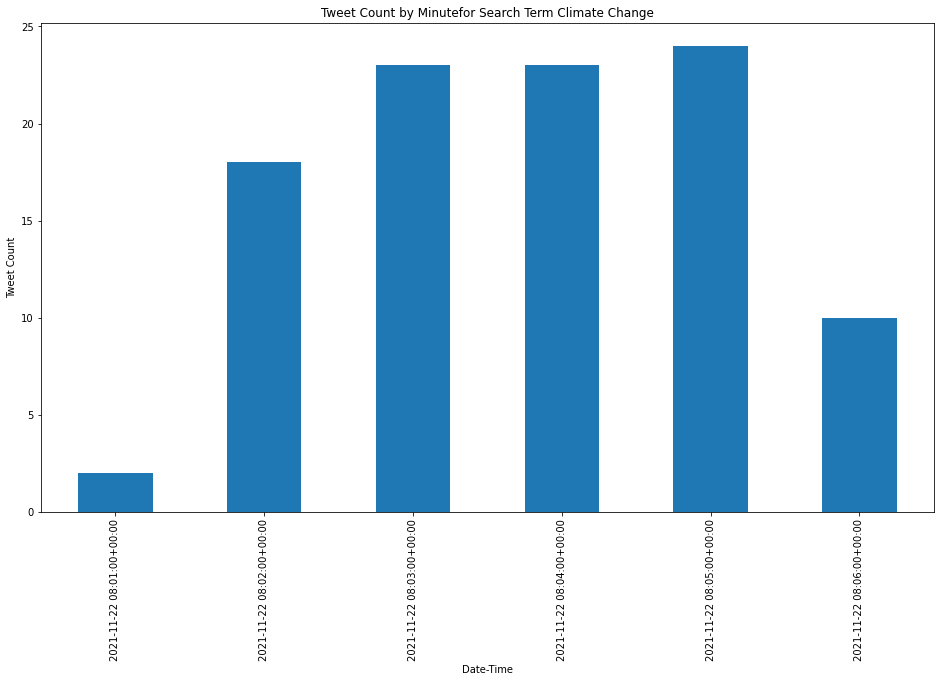

In [20]:
t = time_scale(tweets_df)
tweets_df.groupby([pd.Grouper(key = 'created_at', freq=t[0], axis = 0)]).id_str.count().plot.bar(title =('Tweet Count by ' + t[1]) + 'for Search Term ' + (search_term).title(), xlabel = 'Date-Time', ylabel = "Tweet Count")

# A, Y =  year end frequency
# M = month end frequency
# W = weekly frequency
# # D = calendar day frequency
# H = hourly frequency
# T, min = minutely frequency
# S = secondly frequency

## Emotion Detection

In [21]:
emotion = nlu.load('emotion')
emo_text = emotion.predict(tweets_df.clean_tweet, output_level='document')
emo_text.head()

classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,emotion,emotion_confidence_confidence
0,Though low income and disadvantaged communitie...,joy,0.999986
1,Greta Thunberg is high priestess of a hysteric...,fear,0.998176
2,The regularity of these events points to clima...,fear,1.000000
3,Excited to welcome our expert panelist for Dha...,fear,0.999981
4,As have been discussed a large number of times...,fear,1.000000


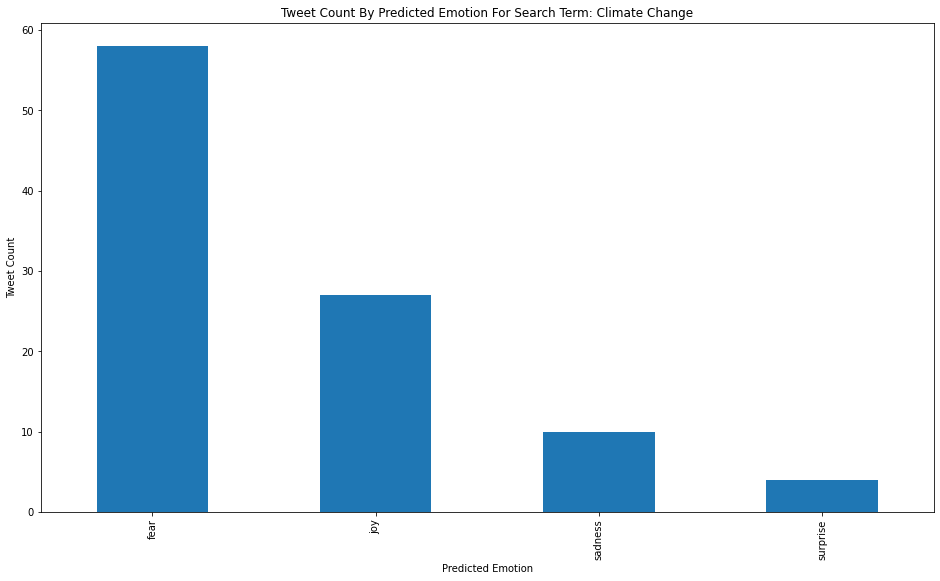

In [22]:
emo_text.emotion.value_counts().plot.bar(title =('Tweet Count by Predicted Emotion for Search Term: ' + search_term).title(), xlabel = 'Predicted Emotion', ylabel = "Tweet Count")

In [23]:
tweets_df = tweets_df.join(emo_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000


## Sentiment Analysis

In [24]:
sentiment = nlu.load('sentiment')
sentiment_text = sentiment.predict(tweets_df.clean_tweet)
sentiment_text.head()

sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentiment,sentiment_confidence
0,Though low income and disadvantaged communitie...,neg,0.997968
1,Greta Thunberg is high priestess of a hysteric...,pos,0.998913
2,The regularity of these events points to clima...,neg,0.998453
3,Excited to welcome our expert panelist for Dha...,pos,0.999941
4,As have been discussed a large number of times...,pos,0.999933


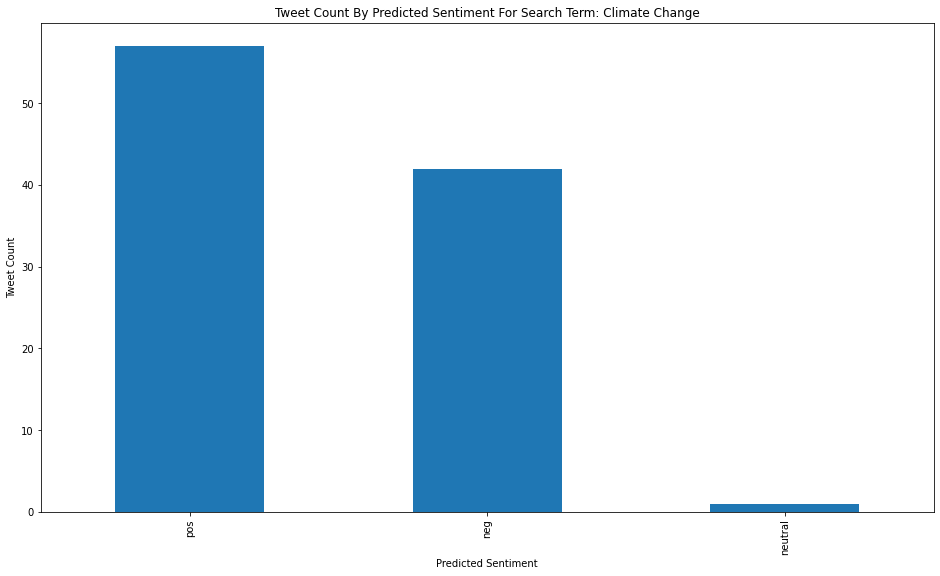

In [25]:
sentiment_text.sentiment.value_counts().plot.bar(title =('Tweet Count by Predicted Sentiment for Search Term: ' + search_term).title(), xlabel = 'Predicted Sentiment', ylabel = "Tweet Count")

In [26]:
tweets_df = tweets_df.join(sentiment_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933


## Twitter Trained Sentiment Analysis

In [27]:
# Sentiment Prediction Trained for Twitter
sentiment_twitter = nlu.load('en.sentiment.twitter')
sentiment_twitter_text = sentiment_twitter.predict(tweets_df.clean_tweet)
sentiment_twitter_text.head()

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 935.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentiment,sentiment_confidence
0,Though low income and disadvantaged communitie...,negative,0.805132
1,Greta Thunberg is high priestess of a hysteric...,positive,1.000000
2,The regularity of these events points to clima...,negative,1.000000
3,Excited to welcome our expert panelist for Dha...,positive,1.000000
4,As have been discussed a large number of times...,negative,0.723399


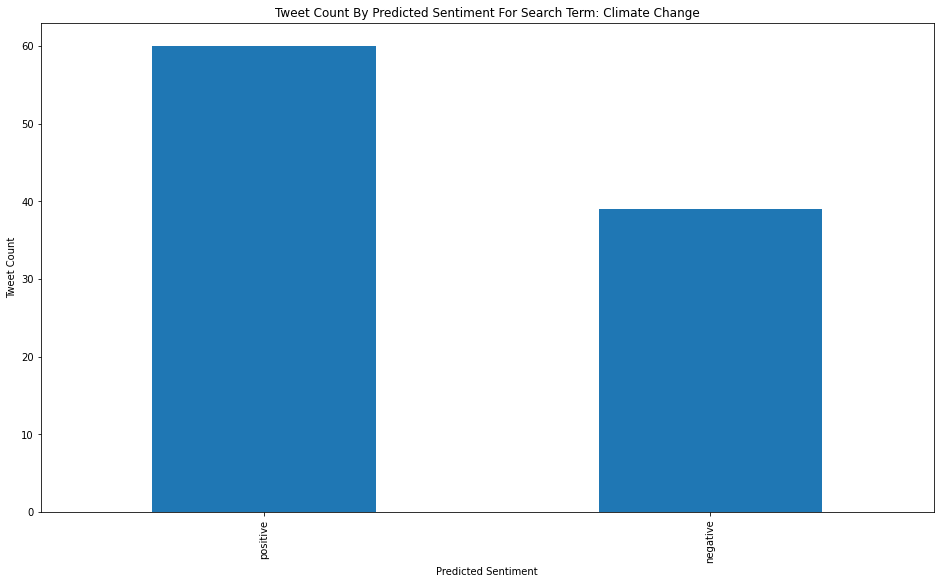

In [28]:
sentiment_twitter_text.sentiment.value_counts().plot.bar(title =('Tweet Count by Predicted Sentiment for Search Term: ' + search_term).title(), xlabel = 'Predicted Sentiment', ylabel = "Tweet Count")

In [29]:
sentiment_twitter_text = sentiment_twitter_text.rename(columns={'sentiment' : 'sentiment_twitter', 'sentiment_confidence': 'sentiment_twitter_confidence'})
tweets_df = tweets_df.join(sentiment_twitter_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968,negative,0.805132
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913,positive,1.000000
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453,negative,1.000000
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941,positive,1.000000
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399


## Fake News Classification

In [31]:
fake_news = nlu.load('en.classify.fakenews')
fake_news_text = fake_news.predict(tweets_df.clean_tweet, output_level='document')
fake_news_text.head()

classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,fakenews,fakenews_confidence_confidence
0,Though low income and disadvantaged communitie...,FAKE,0.998644
1,Greta Thunberg is high priestess of a hysteric...,FAKE,0.999999
2,The regularity of these events points to clima...,REAL,0.983756
3,Excited to welcome our expert panelist for Dha...,FAKE,1.000000
4,As have been discussed a large number of times...,FAKE,0.983445


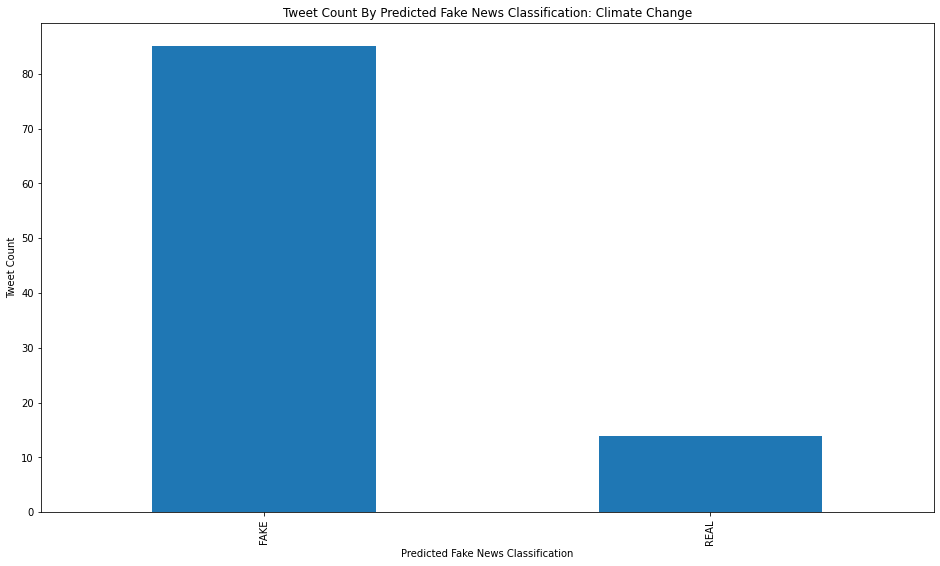

In [32]:
fake_news_text.fakenews.value_counts().plot.bar(title =('Tweet Count by Predicted Fake News Classification: ' + search_term).title(), xlabel = 'Predicted Fake News Classification', ylabel = "Tweet Count")

In [33]:
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968,negative,0.805132
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913,positive,1.000000
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453,negative,1.000000
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941,positive,1.000000
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462692850299285505,2021-11-22 08:02:05+00:00,1462692850299285505,RT @Tonya_Song: If you're going to talk about ...,RT @Tonya_Song: If you're going to talk about ...,RT @Tonya_Song: If you're going to talk about ...,False,363,False,False,<NA>,If you are going to talk about the fakeness of...,joy,0.999269,pos,0.976146,positive,1.000000
96,1462692849380737028,2021-11-22 08:02:05+00:00,1462692849380737028,RT @CarbonBrief: Recommended read: Climate cha...,RT @CarbonBrief: Recommended read: Climate cha...,RT @CarbonBrief: Recommended read: Climate cha...,False,24,False,False,<NA>,Recommended read Climate change deniers are ov...,fear,1.000000,neg,0.994529,negative,1.000000
97,1462692840186814464,2021-11-22 08:02:03+00:00,1462692840186814464,Climate change is affecting coffee flavor and ...,Climate change is affecting coffee flavor and ...,Climate change is affecting coffee flavor and ...,False,0,False,False,False,Climate change is affecting coffee flavor and ...,joy,0.999969,pos,1.000000,negative,1.000000
98,1462692789225938946,2021-11-22 08:01:51+00:00,1462692789225938946,RT @UNBiodiversity: Our food doesn’t have to c...,RT @UNBiodiversity: Our food doesn’t have to c...,RT @UNBiodiversity: Our food doesn’t have to c...,False,50,False,False,<NA>,Our food does not have to come at the expense ...,sadness,0.999870,neg,0.976707,negative,1.000000


In [34]:
tweets_df = tweets_df.join(fake_news_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968,negative,0.805132,FAKE,0.998644
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913,positive,1.000000,FAKE,0.999999
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453,negative,1.000000,REAL,0.983756
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941,positive,1.000000,FAKE,1.000000
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399,FAKE,0.983445


In [35]:
tweets_df[tweets_df['fakenews']=='REAL'].sample(5)

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence
64,1462693260988583943,2021-11-22 08:03:43+00:00,1462693260988583943,RT @nytimes: Among childless adults in the Uni...,RT @nytimes: Among childless adults in the Uni...,RT @nytimes: Among childless adults in the Uni...,False,274,False,False,<NA>,Among childless adults in the United States su...,fear,0.999918,pos,0.999510,positive,0.871994,REAL,0.983662
10,1462693824354873345,2021-11-22 08:05:57+00:00,1462693824354873345,RT @LizanneFoster: Would @bcndp govt behave di...,RT @LizanneFoster: Would @bcndp govt behave di...,RT @LizanneFoster: Would @bcndp govt behave di...,False,11,False,False,<NA>,Would govt behave differently if former Fraser...,fear,1.000000,neg,0.999924,negative,1.000000,REAL,0.772168
50,1462693398456852484,2021-11-22 08:04:16+00:00,1462693398456852484,RT @CharlieJGardner: The idea that rich countr...,RT @CharlieJGardner: The idea that rich countr...,RT @CharlieJGardner: The idea that rich countr...,False,560,False,False,False,The idea that rich countries are not taking st...,fear,1.000000,pos,0.757485,positive,0.870663,REAL,0.964587
36,1462693567428657152,2021-11-22 08:04:56+00:00,1462693567428657152,RT @TimBuckleyIEEFA: Excellent @MikeSeccombe r...,RT @TimBuckleyIEEFA: Excellent @MikeSeccombe r...,RT @TimBuckleyIEEFA: Excellent @MikeSeccombe r...,False,27,False,False,<NA>,Excellent review of how has Australia playing ...,fear,0.999990,pos,1.000000,positive,1.000000,REAL,0.563571
99,1462692785702666241,2021-11-22 08:01:50+00:00,1462692785702666241,RT @Spanishcountry: CEO Larry Fink is a hypocr...,<NA>,RT @Spanishcountry: CEO Larry Fink is a hypocr...,False,1,False,False,<NA>,CEO Larry Fink is a hypocrite. He likes to tal...,fear,0.999230,neg,0.999311,positive,1.000000,REAL,0.942409


## Spam Classification

In [36]:
 spam = nlu.load('en.classify.spam')
 spam_df = spam.predict(tweets_df.clean_tweet, output_level='document')
 spam_df.head()

classifierdl_use_spam download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,spam,spam_confidence_confidence
0,Though low income and disadvantaged communitie...,ham,1.000000
1,Greta Thunberg is high priestess of a hysteric...,ham,1.000000
2,The regularity of these events points to clima...,ham,1.000000
3,Excited to welcome our expert panelist for Dha...,ham,1.000000
4,As have been discussed a large number of times...,ham,1.000000
...,...,...,...
95,If you are going to talk about the fakeness of...,ham,1.000000
96,Recommended read Climate change deniers are ov...,ham,0.969437
97,Climate change is affecting coffee flavor and ...,ham,1.000000
98,Our food does not have to come at the expense ...,ham,1.000000


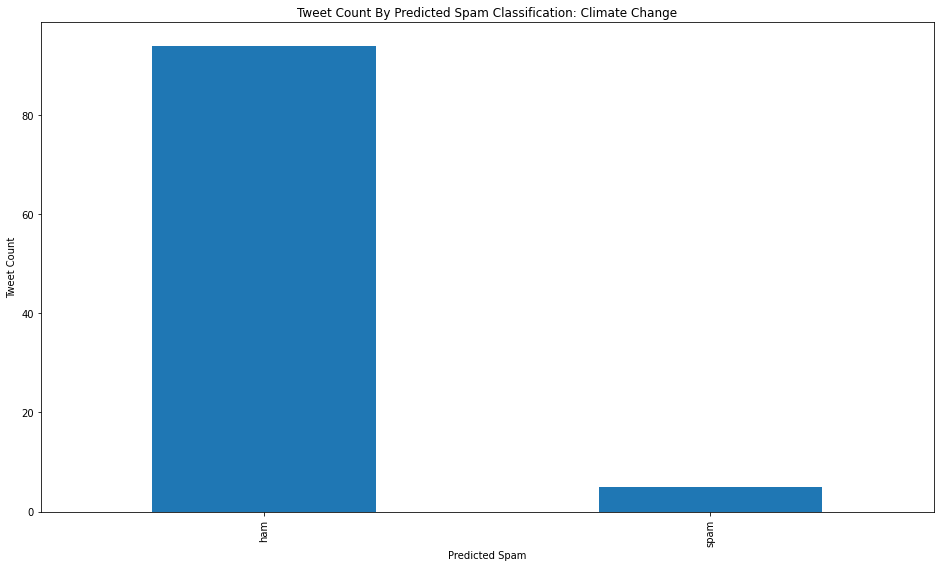

In [37]:
spam_df.spam.value_counts().plot.bar(title =('Tweet Count by Predicted Spam Classification: ' + search_term).title(), xlabel = 'Predicted Spam', ylabel = "Tweet Count")

In [38]:
tweets_df = tweets_df.join(spam_df)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968,negative,0.805132,FAKE,0.998644,ham,1.0
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913,positive,1.000000,FAKE,0.999999,ham,1.0
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453,negative,1.000000,REAL,0.983756,ham,1.0
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941,positive,1.000000,FAKE,1.000000,ham,1.0
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399,FAKE,0.983445,ham,1.0


In [65]:
tweets_df[tweets_df['spam']=='spam'].sample(5)

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence
35,1462693568225632259,2021-11-22 08:04:56+00:00,1462693568225632259,RT @stevescotttweet: New fund from @UKRI_News ...,RT @stevescotttweet: New fund from @UKRI_News ...,RT @stevescotttweet: New fund from @UKRI_News ...,False,2,False,False,<NA>,New fund from to support communities in the Hi...,joy,0.999050,pos,1.000000,positive,1.000000,FAKE,0.999999,spam,0.683049,non-toxic,NaN
8,1462693873738780679,2021-11-22 08:06:09+00:00,1462693873738780679,RT @EPHconference: (Public) health organisatio...,RT @EPHconference: (Public) health organisatio...,RT @EPHconference: (Public) health organisatio...,False,5,False,False,<NA>,Public health organisations and member associa...,fear,1.000000,pos,0.999947,negative,0.997999,FAKE,0.999988,spam,0.665366,non-toxic,NaN
75,1462693118134915073,2021-11-22 08:03:09+00:00,1462693118134915073,RT @EU_Commission: Got questions? We answer wi...,RT @EU_Commission: Got questions? We answer wi...,RT @EU_Commission: Got questions? We answer wi...,False,13,False,False,<NA>,Got questions We answer with data bar chart Fr...,fear,0.766953,pos,0.999620,positive,1.000000,FAKE,0.999729,spam,0.999483,non-toxic,NaN
36,1462693567428657152,2021-11-22 08:04:56+00:00,1462693567428657152,RT @TimBuckleyIEEFA: Excellent @MikeSeccombe r...,RT @TimBuckleyIEEFA: Excellent @MikeSeccombe r...,RT @TimBuckleyIEEFA: Excellent @MikeSeccombe r...,False,27,False,False,<NA>,Excellent review of how has Australia playing ...,fear,0.999990,pos,1.000000,positive,1.000000,REAL,0.563571,spam,0.997217,non-toxic,NaN
74,1462693120592814088,2021-11-22 08:03:10+00:00,1462693120592814088,"NRW at #WalesClimateWeek Our CEO, Clare Pillm...","NRW at #WalesClimateWeek Our CEO, Clare Pillm...","NRW at #WalesClimateWeek Our CEO, Clare Pillm...",True,1,False,False,False,NRW at WalesClimateWeek Our CEO Clare Pillman ...,joy,0.999980,pos,0.999980,positive,1.000000,FAKE,0.999919,spam,0.864563,non-toxic,NaN


## Toxic Classification

In [40]:
toxic = nlu.load('en.classify.toxic')
toxic_df = toxic.predict(tweets_df.clean_tweet, output_level='document')
toxic_df.head()

multiclassifierdl_use_toxic download started this may take some time.
Approximate size to download 11.6 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,toxic,toxic_confidence_confidence
0,Though low income and disadvantaged communitie...,NaN,NaN
1,Greta Thunberg is high priestess of a hysteric...,NaN,NaN
2,The regularity of these events points to clima...,NaN,NaN
3,Excited to welcome our expert panelist for Dha...,NaN,NaN
4,As have been discussed a large number of times...,NaN,NaN


In [41]:
tweets_df = tweets_df.join(toxic_df)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968,negative,0.805132,FAKE,0.998644,ham,1.0,NaN,NaN
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913,positive,1.000000,FAKE,0.999999,ham,1.0,NaN,NaN
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453,negative,1.000000,REAL,0.983756,ham,1.0,NaN,NaN
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941,positive,1.000000,FAKE,1.000000,ham,1.0,NaN,NaN
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399,FAKE,0.983445,ham,1.0,NaN,NaN


In [45]:
tweets_df['toxic'] = tweets_df['toxic'].replace(np.nan, 'non-rated')
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968,negative,0.805132,FAKE,0.998644,ham,1.0,non-toxic,NaN
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913,positive,1.000000,FAKE,0.999999,ham,1.0,non-toxic,NaN
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453,negative,1.000000,REAL,0.983756,ham,1.0,non-toxic,NaN
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941,positive,1.000000,FAKE,1.000000,ham,1.0,non-toxic,NaN
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399,FAKE,0.983445,ham,1.0,non-toxic,NaN


In [59]:
toxic_df = toxic_df.explode('toxic')
toxic_df['toxic'] = toxic_df['toxic'].replace(np.nan, 'non-rated')
toxic_df.head()

,document,toxic,toxic_confidence_confidence
0,Though low income and disadvantaged communitie...,non-rated,NaN
1,Greta Thunberg is high priestess of a hysteric...,non-rated,NaN
2,The regularity of these events points to clima...,non-rated,NaN
3,Excited to welcome our expert panelist for Dha...,non-rated,NaN
4,As have been discussed a large number of times...,non-rated,NaN


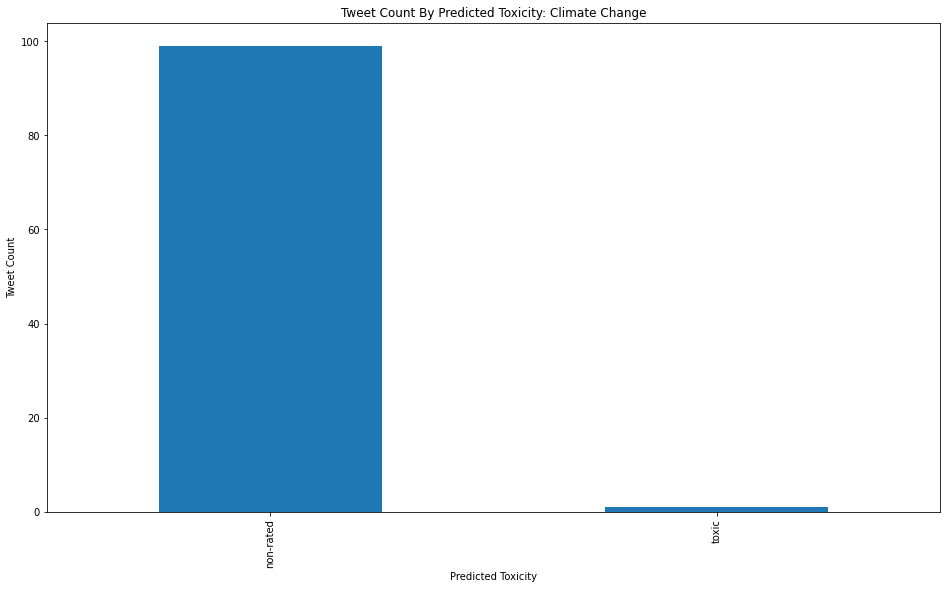

In [60]:
toxic_df.toxic.value_counts().plot.bar(title =('Tweet Count by Predicted Toxicity: ' + search_term).title(), xlabel = 'Predicted Toxicity', ylabel = "Tweet Count")

In [57]:
toxic_df[toxic_df['toxic']=='toxic'].sample()

[nan 'toxic']


,document,toxic,toxic_confidence_confidence
30,they are basterdizing barlcanising rendering u...,toxic,[0.5413918]


## Sarcasm Classification

In [63]:
sarcasm = nlu.load('en.classify.sarcasm')
sarcasm_df = sarcasm.predict(tweets_df.clean_tweet, output_level='document')
sarcasm_df.head()

classifierdl_use_sarcasm download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sarcasm,sarcasm_confidence_confidence
0,Though low income and disadvantaged communitie...,normal,0.880871
1,Greta Thunberg is high priestess of a hysteric...,normal,0.999999
2,The regularity of these events points to clima...,normal,0.769813
3,Excited to welcome our expert panelist for Dha...,normal,0.999993
4,As have been discussed a large number of times...,sarcasm,0.986510


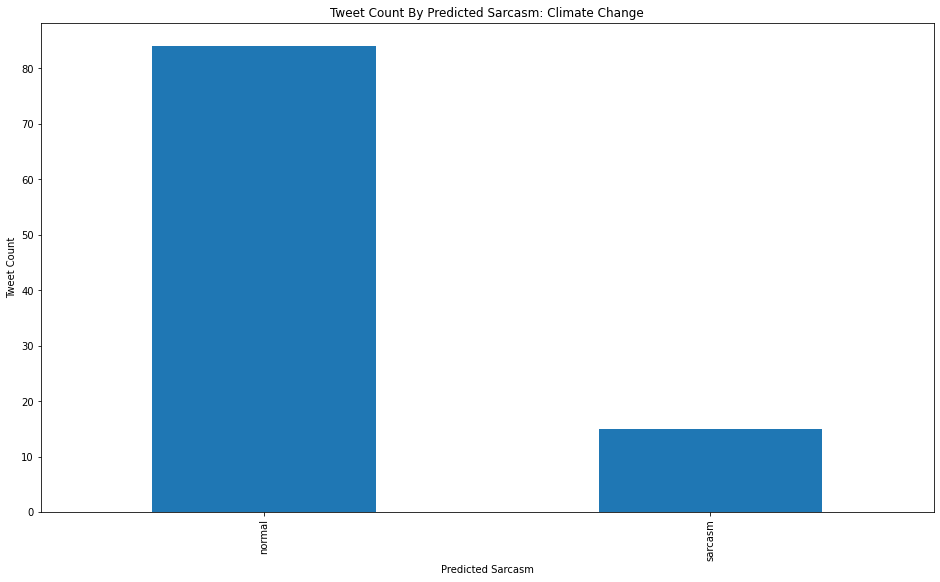

In [64]:
sarcasm_df.sarcasm.value_counts().plot.bar(title =('Tweet Count by Predicted Sarcasm: ' + search_term).title(), xlabel = 'Predicted Sarcasm', ylabel = "Tweet Count")

In [66]:
tweets_df = tweets_df.join(sarcasm_df)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence,sarcasm,sarcasm_confidence_confidence
0,1462693963903770624,2021-11-22 08:06:31+00:00,1462693963903770624,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,RT @WorldResources: Though low-income and disa...,False,1,False,False,<NA>,Though low income and disadvantaged communitie...,joy,0.999986,neg,0.997968,negative,0.805132,FAKE,0.998644,ham,1.0,non-toxic,NaN,normal,0.880871
1,1462693956802777092,2021-11-22 08:06:29+00:00,1462693956802777092,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,RT @nigella_i5e: Greta Thunberg is high priest...,False,7,False,False,False,Greta Thunberg is high priestess of a hysteric...,fear,0.998176,pos,0.998913,positive,1.000000,FAKE,0.999999,ham,1.0,non-toxic,NaN,normal,0.999999
2,1462693935017455625,2021-11-22 08:06:24+00:00,1462693935017455625,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,RT @zenrainman: @srinualavilli The regularity ...,False,4,False,False,<NA>,The regularity of these events points to clima...,fear,1.000000,neg,0.998453,negative,1.000000,REAL,0.983756,ham,1.0,non-toxic,NaN,normal,0.769813
3,1462693923478917124,2021-11-22 08:06:21+00:00,1462693923478917124,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,RT @DharitriLive1: Excited to welcome our expe...,False,1,False,False,<NA>,Excited to welcome our expert panelist for Dha...,fear,0.999981,pos,0.999941,positive,1.000000,FAKE,1.000000,ham,1.0,non-toxic,NaN,normal,0.999993
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399,FAKE,0.983445,ham,1.0,non-toxic,NaN,sarcasm,0.986510


In [67]:
tweets_df[tweets_df['sarcasm']=='sarcasm'].sample(5)

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence,sarcasm,sarcasm_confidence_confidence
96,1462692849380737028,2021-11-22 08:02:05+00:00,1462692849380737028,RT @CarbonBrief: Recommended read: Climate cha...,RT @CarbonBrief: Recommended read: Climate cha...,RT @CarbonBrief: Recommended read: Climate cha...,False,24,False,False,<NA>,Recommended read Climate change deniers are ov...,fear,1.000000,neg,0.994529,negative,1.000000,FAKE,0.999989,ham,0.969437,non-toxic,NaN,sarcasm,0.622232
32,1462693591667683328,2021-11-22 08:05:02+00:00,1462693591667683328,When we feel compelled to make changes about t...,When we feel compelled to make changes about t...,When we feel compelled to make changes about t...,True,0,False,False,False,When we feel compelled to make changes about t...,fear,0.994691,pos,0.999994,positive,1.000000,FAKE,0.999908,ham,1.000000,non-toxic,NaN,sarcasm,0.916627
4,1462693921352466433,2021-11-22 08:06:21+00:00,1462693921352466433,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,@dad_climate @ClimateDad77 @ChrisGPackham @Ins...,True,0,False,False,<NA>,As have been discussed a large number of times...,fear,1.000000,pos,0.999933,negative,0.723399,FAKE,0.983445,ham,1.000000,non-toxic,NaN,sarcasm,0.986510
58,1462693310947016709,2021-11-22 08:03:55+00:00,1462693310947016709,British Columbia's Flooding Is Worse Because o...,British Columbia's Flooding Is Worse Because o...,British Columbia's Flooding Is Worse Because o...,False,0,False,False,False,British Columbia s Flooding Is Worse Because o...,fear,0.999604,neg,0.979366,negative,1.000000,FAKE,0.973306,ham,0.999999,non-toxic,NaN,sarcasm,0.996905
88,1462692934776668163,2021-11-22 08:02:25+00:00,1462692934776668163,@nicktolhurst I see that climate change will f...,@nicktolhurst I see that climate change will f...,@nicktolhurst I see that climate change will f...,True,0,False,False,<NA>,I see that climate change will flood South Tha...,fear,1.000000,pos,0.999430,negative,0.992093,FAKE,0.880135,ham,1.000000,non-toxic,NaN,sarcasm,0.931679


## Keyword Extraction

In [70]:
yake = nlu.load('yake')
yake['yake'].setThreshold(.50)  
yake_df = yake.predict(tweets_df.clean_tweet)
yake_df.head()

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,keywords,keywords_confidence
0,Though low income and disadvantaged communitie...,NaN,NaN
1,Greta Thunberg is high priestess of a hysteric...,story,0.26804494089513314
1,Greta Thunberg is high priestess of a hysteric...,alex story,0.1840422979793308
1,Greta Thunberg is high priestess of a hysteric...,says alex story,0.2634928160010704
2,The regularity of these events points to clima...,areas,0.39555771794771377


In [ ]:
# yake.print_info()
# yake['yake'].setMinNGrams(1)
# yake['yake'].setMaxNGrams(3)
# yake_text = yake.predict(text.cleanText)
# yake_text

In [ ]:
yake_text.keywords.value_counts()[:50].plot.bar()

#If df had a column with multiple keywords use:
# yake_text.explode('keywords).keywords.value_counts()[0:100].plot.bar()

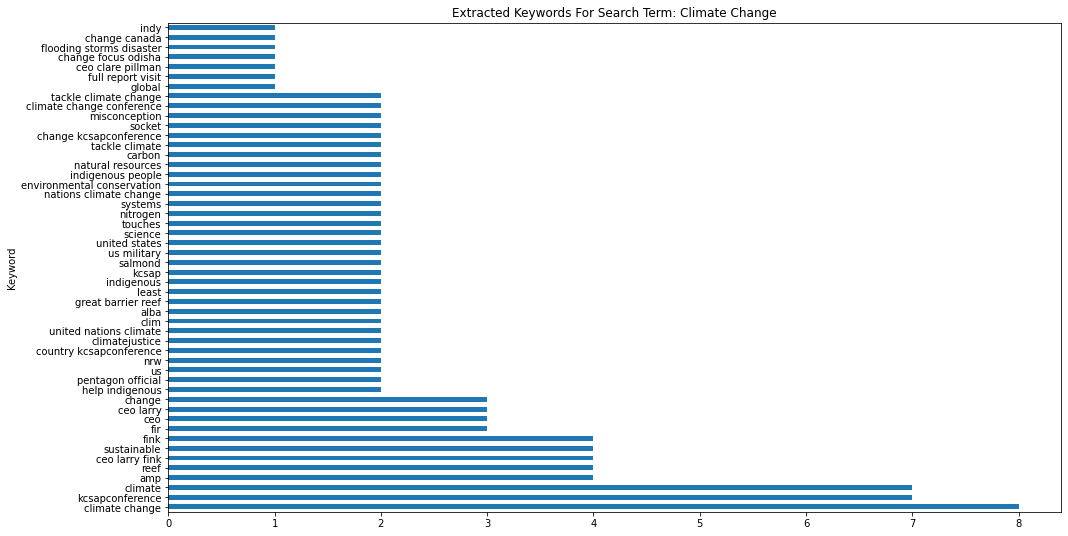

In [77]:
yake_df.keywords.value_counts()[0:50].plot.barh(title =('Extracted Keywords for Search Term: ' + search_term).title(), xlabel = 'Keyword', ylabel = "Tweet Count")

## Named Entity Recognition

In [79]:
ner = nlu.load('ner')
ner_df = ner.predict(tweets_df.clean_tweet)
ner_df.head()

onto_recognize_entities_sm download started this may take some time.
Approx size to download 160.1 MB
[OK!]


,document,entities,entities_class,entities_confidence
0,Though low income and disadvantaged communitie...,NaN,NaN,NaN
1,Greta Thunberg is high priestess of a hysteric...,Greta Thunberg,PERSON,0.95704997
1,Greta Thunberg is high priestess of a hysteric...,one,CARDINAL,0.791
1,Greta Thunberg is high priestess of a hysteric...,ALEX,PERSON,0.9416
2,The regularity of these events points to clima...,NaN,NaN,NaN


In [109]:
ner_df.groupby(['entities_class'])['entities'].count().sort_values(ascending=False)

entities_class
PERSON         50
CARDINAL       25
ORG            20
GPE            18
DATE           16
LOC            12
NORP            7
EVENT           5
WORK_OF_ART     2
PRODUCT         2
ORDINAL         2
TIME            1
Name: entities, dtype: int64

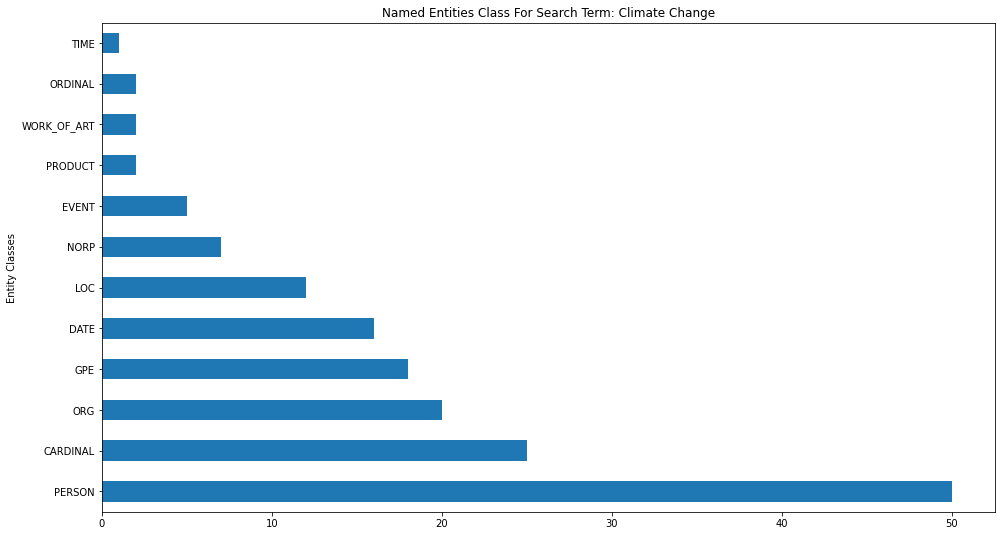

In [110]:
ner_df.entities_class.value_counts()[0:50].plot.barh(title =('Named Entities Classes for Search Term: ' + search_term).title(), xlabel = 'Entity Classes', ylabel = "Tweet Count")

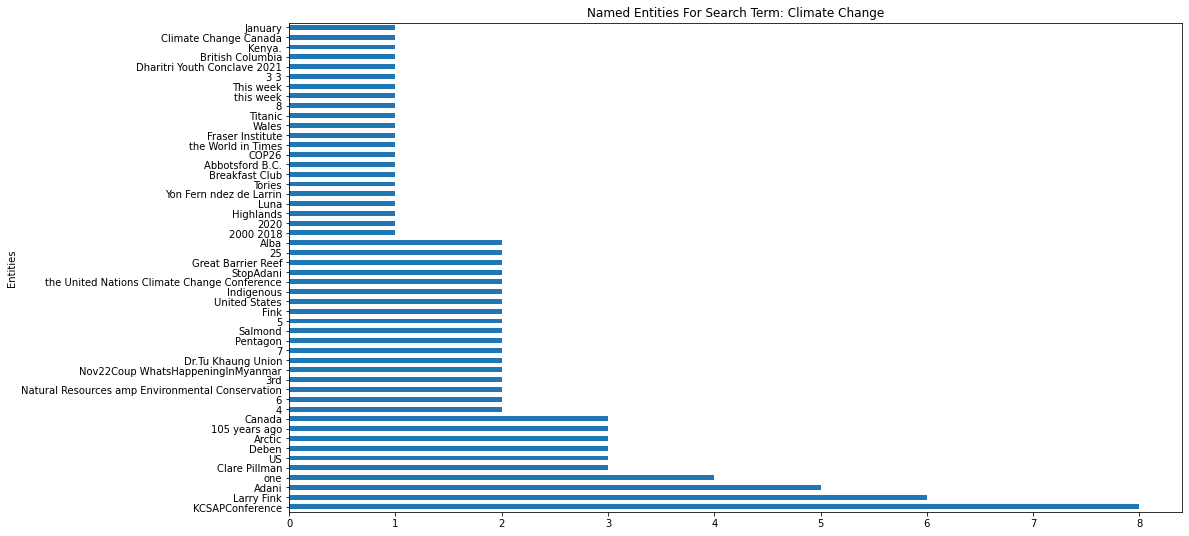

In [117]:
ner_df.entities.value_counts()[0:50].plot.barh(title =('Named Entities for Search Term: ' + search_term).title(), xlabel = 'Entities', ylabel = "Tweet Count")